<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/MobileNet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade imgaug

     |████████████████████████████████| 952kB 3.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
import urllib
import re
from progressbar import ProgressBar

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
IMG_SIZE = 96
def make_square(im, min_size=IMG_SIZE):
    x, y = im.size
    fill_color = im.getpixel((x-1, y-1))
    size = max(min_size, x, y)
    new_im = Image.new('RGB', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return np.asarray(new_im)

In [5]:
original_folder = "/content/drive/My Drive/Colab Notebooks/immagini_originali"

original_images = []
names = []
pbar = ProgressBar()
for file in pbar(os.listdir(original_folder)):
  family = re.sub("stemma |.gif", "", re.sub("%20|%2520", " ", file.lower()))
  names.append(family)
  file_path = os.path.join(original_folder, file)
  array = make_square(Image.open(file_path).convert("RGB"))
  original_images.append(array)

100% (584 of 584) |######################| Elapsed Time: 0:02:41 Time:  0:02:41


### Immagini Originali - 584 stemmi ###
I titoli sono presi dai nomi dei file da *nobili-napoletani.it*

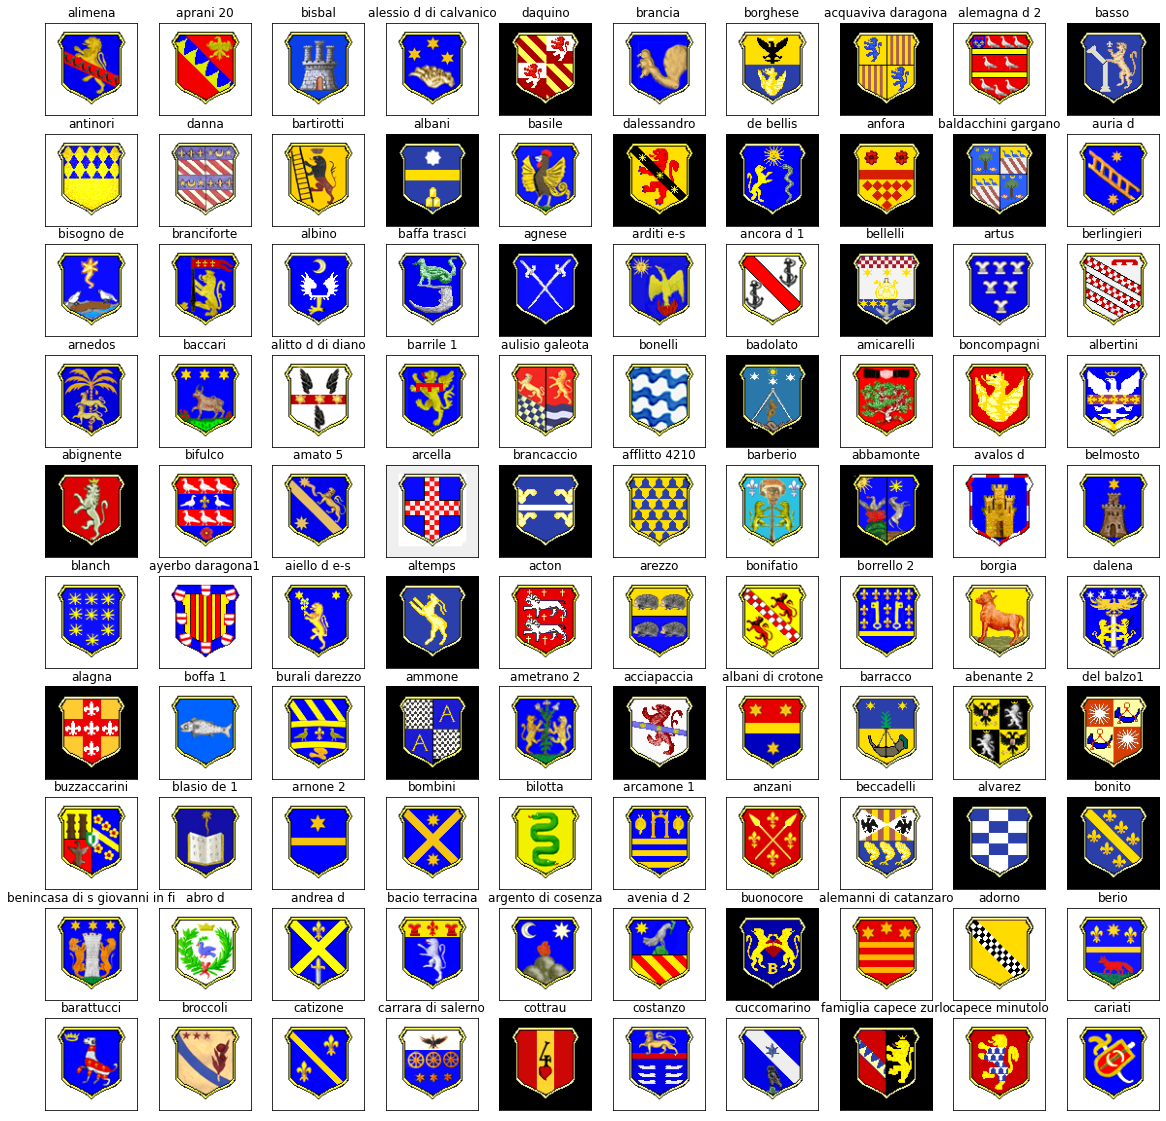

In [6]:
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow(original_images[i])
  axs[i].set(title=names[i], xticks=[], yticks=[])
  
plt.show()

In [7]:
original_labels = tf.keras.utils.to_categorical(range(len(original_images)))

In [10]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.PerspectiveTransform(scale=(0, 0.15)),
    iaa.AdditiveGaussianNoise(scale=(0, 0.05)),
    iaa.Multiply((0.8, 1.2)),
    iaa.Cutout(nb_iterations=(0, 1), size=0.1),
    iaa.JpegCompression(compression=(0, 50)),
    iaa.GaussianBlur(sigma=(0, 1)),
    iaa.GammaContrast((0.5, 1.5)),
    iaa.Affine(scale={"x": (0.7, 1.3), "y": (0.7, 1.3)}),
    iaa.TranslateX(percent=(-0.1, 0.1)),
    iaa.TranslateY(percent=(-0.1, 0.1)),
    iaa.Rotate((-10, 10)),
])

cloned_images = np.repeat(
  np.asarray(original_images), 30, axis=0,
)

pbar = ProgressBar()
for i in pbar(range(len(cloned_images)//8)): # così non finisce la ram...
  cloned_images[8*i : 8*(i+1)] = seq(
      images=cloned_images[8*i : 8*(i+1)]
  )

100% (2190 of 2190) |####################| Elapsed Time: 0:01:12 Time:  0:01:12


In [28]:
seq_bw = iaa.Sequential([
    seq,
    iaa.color.Grayscale(),
])

cloned_images_bw = np.repeat(
  np.asarray(original_images), 30, axis=0,
)

pbar = ProgressBar()
for i in pbar(range(len(cloned_images)//8)): # così non finisce la ram...
  cloned_images_bw[8*i : 8*(i+1)] = seq_bw(
      images=cloned_images_bw[8*i : 8*(i+1)]
  )

100% (2190 of 2190) |####################| Elapsed Time: 0:01:16 Time:  0:01:16


In [35]:
matrix = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

seq_ed = iaa.Sequential([
    seq,
    iaa.Convolve(matrix=matrix),
    iaa.color.Grayscale(),
    iaa.arithmetic.Invert(p=0.5),
])

cloned_images_ed = np.repeat(
  np.asarray(original_images), 30, axis=0,
)

pbar = ProgressBar()
for i in pbar(range(len(cloned_images)//8)): # così non finisce la ram...
  cloned_images_ed[8*i : 8*(i+1)] = seq_ed(
      images=cloned_images_ed[8*i : 8*(i+1)]
  )

100% (2190 of 2190) |####################| Elapsed Time: 0:01:20 Time:  0:01:20


In [37]:
aug_images = np.concatenate((cloned_images, cloned_images_bw, cloned_images_ed))
cloned_labels = np.repeat(original_labels, 30, axis=0)
aug_labels = np.concatenate((cloned_labels, cloned_labels, cloned_labels))

### Data Augmentation ###
584 immagini sono poche per il training e inoltre essendo "perfette" non riproducono la variabilità di luminosità, rotazione, contrasto, rumore, sfocatura, prospettiva, pixelatura che c'è negli stemmi fotografati o estrapolati dagli indizi. Simulo quindi tutti questi effetti su 30 cloni di ogni stemma.

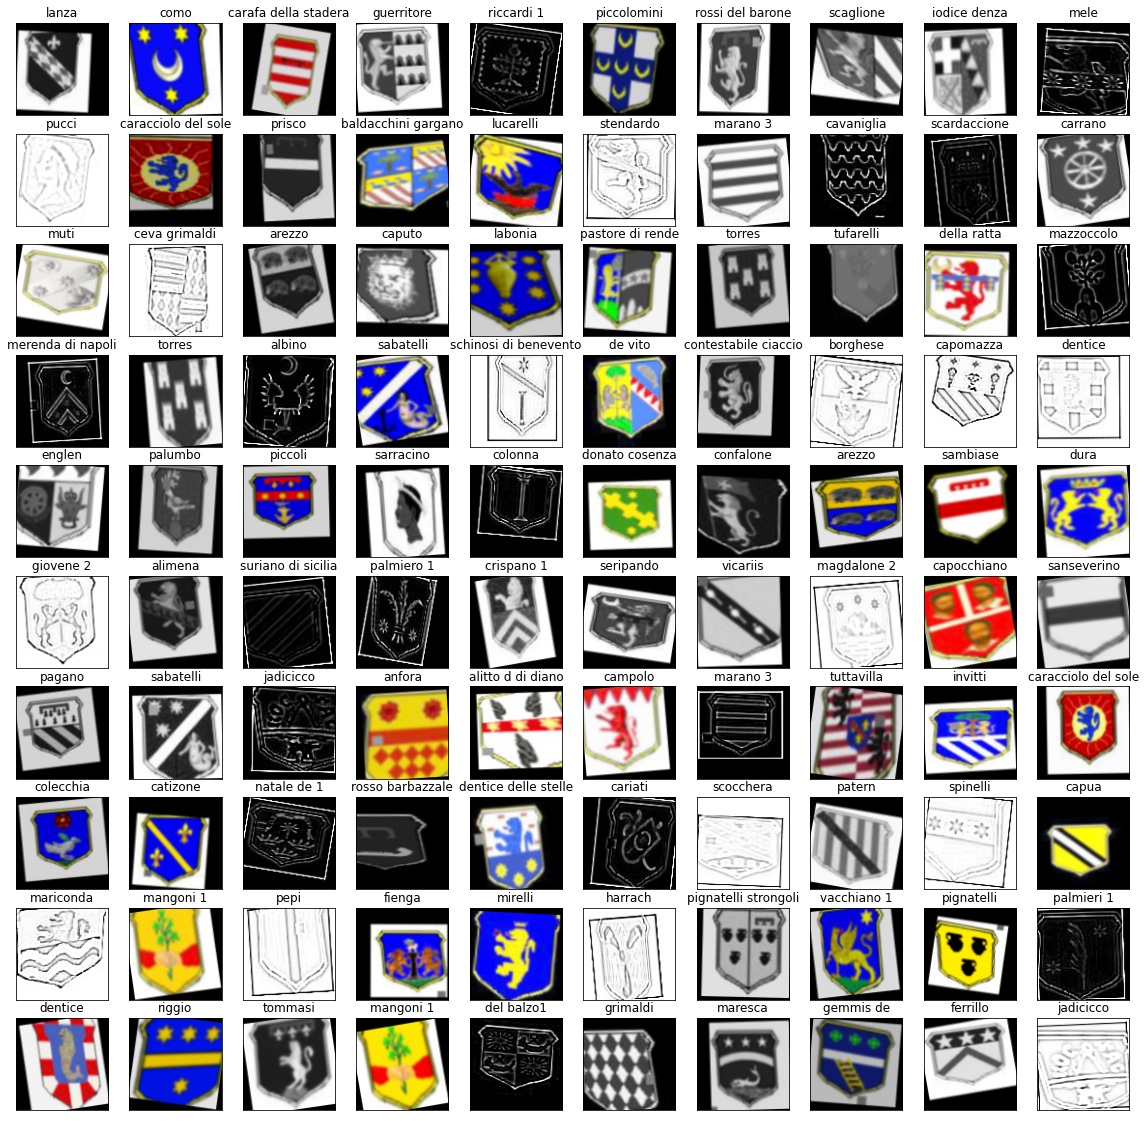

In [38]:
#example
rnd = np.random.randint(0, high=len(aug_images), size=100)
fig, ax_mat = plt.subplots(10, 10, figsize=(20, 20))
axs = np.ravel(ax_mat)
for i in range(100):
  axs[i].imshow((aug_images[rnd[i]]))
  axs[i].set(title = names[np.argmax(aug_labels[rnd[i]])], xticks=[], yticks=[])
plt.show()

Divido il campione in 2 pezzi, per il training e per i test.

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test \
    = train_test_split(
        cloned_images.astype(np.float32)/127.5-1, #normalizing
        cloned_labels, 
        test_size=0.2, random_state=1
)

In [40]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [41]:
# Let's take a look at the base model architecture
base_model.trainable = False

# base_model.summary()

In [42]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [43]:
prediction_layer = tf.keras.layers.Dense(584, activation="softmax")

In [44]:
with tf.device("/gpu:0"):
  model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
  ])

In [45]:
base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
with tf.device("/gpu:0"):
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy', 'top_k_categorical_accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 584)               748104    
Total params: 3,006,088
Trainable params: 748,104
Non-trainable params: 2,257,984
_________________________________________________________________


In [48]:
!nvidia-smi
print(tf.test.gpu_device_name())
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Fri Sep 25 07:33:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |    391MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4634382762610987706, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 17249576113524321369
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1944411097973853794
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15695549568
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15326683393731758858
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

Eseguo il training.

In [50]:
BATCH_SIZE = 128
with tf.device("/gpu:0"):
  history = model.fit(x=X_train, y=Y_train,
                      epochs=280,
                      validation_split=0.25, batch_size=BATCH_SIZE)

Epoch 1/280
83/83 [==============================] - 3s 33ms/step - loss: 0.6925 - accuracy: 0.9911 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.6926 - val_accuracy: 0.9526 - val_top_k_categorical_accuracy: 0.9829
Epoch 2/280
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9911 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.6926 - val_accuracy: 0.9523 - val_top_k_categorical_accuracy: 0.9829
Epoch 3/280
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9911 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.6926 - val_accuracy: 0.9526 - val_top_k_categorical_accuracy: 0.9829
Epoch 4/280
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9911 - top_k_categorical_accuracy: 0.9911 - val_loss: 0.6926 - val_accuracy: 0.9526 - val_top_k_categorical_accuracy: 0.9829
Epoch 5/280
83/83 [==============================] - 3s 32ms/step - loss: 0.6925 - accuracy: 0.9911 - top_k_categorical_

KeyboardInterrupt: ignored

Nella figura in basso è rappresentato l'andamento del training.

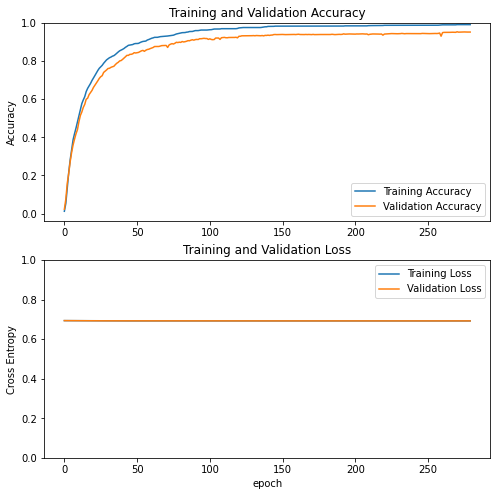

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Salvo il modello per non doverlo riallenare.

In [52]:
model.save("/content/drive/My Drive/Colab Notebooks/stemmi.hdf5")

Valuto le prestazioni dell'algoritmo sul campione di test. Meno di campione su 20 è mal classificato.

In [53]:
test_score = model.evaluate(x=X_test, y=Y_test)
print(f"Test accuracy: {test_score[1]}")

28/28 [==============================] - 1s 23ms/step - loss: 0.6926 - accuracy: 0.9509 - top_k_categorical_accuracy: 0.9832
Test accuracy: 0.9509132504463196


In meno di un caso su 50 la famiglia corretta non è indicata tra le 5 più probabili, data un immagine di test.

In [54]:
y_pred = model.predict(X_test)
top_5_acc = tf.keras.metrics.top_k_categorical_accuracy(Y_test, y_pred, k=5)
print(f"Top 5 test accuracy: {np.mean(top_5_acc)}")

Top 5 test accuracy: 0.982876718044281


In meno di un caso su 50 la famiglia corretta non è indicata tra le 10 più probabili, data un immagine di test.

In [55]:
top_5_acc = tf.keras.metrics.top_k_categorical_accuracy(Y_test, y_pred, k=10)
print(f"Top 10 test accuracy: {np.mean(top_5_acc)}")

Top 10 test accuracy: 0.984874427318573


I risultati sono molto incoraggianti, soprattutto se considerato che gli stemmi di interesse reale sono meno di 100, a fronte dei 600 usati. Le prestazioni quindi miglioreranno sensibilmente.

Provo a vedere se l'algoritmo classifica correttamente uno stemma ritagliato da un "indizio", ossia dalla foto nel post di nemesi che annunciava l'ingresso nel comitato di Domenico Spasiano.

Mostro la foto originale e il ritaglio.

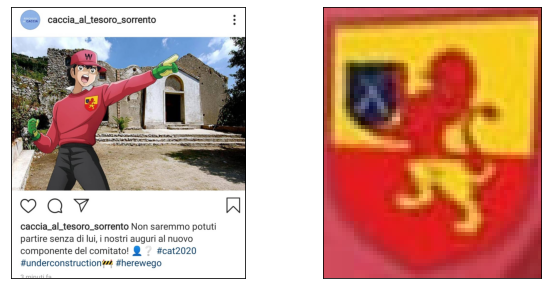

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(Image.open("/content/drive/My Drive/Colab Notebooks/post.jpeg"))
axs[0].set(xticks=[], yticks=[])
cut = Image.open("/content/drive/My Drive/Colab Notebooks/tosearch.jpeg")
axs[1].imshow(cut)
axs[1].set(xticks=[], yticks=[])
plt.show()

Preparo il ritaglio per essere processato dalla rete.

In [59]:
cut_norm = make_square(cut).astype(np.float32)/127.5-1
# ora calcolo le probabilità che la foto sia associata alle varie famiglie.
probs = model.predict(np.array([cut_norm]))

La prima delle 3 famiglie più probabili che la rete associa alla foto è proprio quella corretta: **Spasiano**. <br>

L'algoritmo quindi si è comportato nel modo previsto in un caso di utilizzo reale.

In [60]:
top_values_index = sorted(range(len(probs[0])), key=lambda i: probs[0][i], reverse=True)[:3]
for i, index in enumerate(top_values_index):
  print(f"{i+1}°: {names[index]}. \t\t Probabilità: {probs[0][index]:.2f}")

1°: spasiano. 		 Probabilità: 0.59
2°: petra. 		 Probabilità: 0.30
3°: massara. 		 Probabilità: 0.04


Lo stemma della famiglia spasiano è proprio identico a quello di interesse.

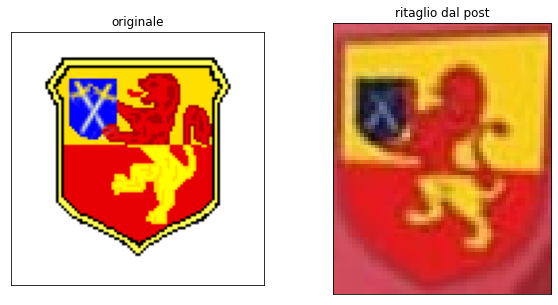

In [61]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_images[top_values_index[0]])
axs[0].set(title="originale", xticks=[], yticks=[])
axs[1].imshow(cut)
axs[1].set(title="ritaglio dal post", xticks=[], yticks=[])
plt.show()

In [62]:
def test(file_path):
  test = Image.open(file_path).convert("RGB")
  max_ind, min_ind = np.argmax(test.size), np.argmin(test.size)
  max_size, min_size = max(test.size), min(test.size)
  if max_size > 96 or min_size < 50:
    new_size = [0, 0]
    new_size[max_ind] = 96
    new_size[min_ind] = int(96*min_size/max_size)
    test = test.resize(new_size)

  model = tf.keras.models.load_model("/content/drive/My Drive/Colab Notebooks/stemmi.hdf5")
  test_norm = make_square(test).astype(np.float32)/127.5-1
  # ora calcolo le probabilità che la foto sia associata alle varie famiglie.
  probs = model.predict(np.array([test_norm]))
  top_values_index = sorted(range(len(probs[0])), key=lambda i: probs[0][i], reverse=True)[:10]
  fig, axs = plt.subplots(10, figsize=(20, 20))
  for i, index in enumerate(top_values_index):
    axs[i].imshow(original_images[index])
    axs[i].set(
        title=f"{i+1}°: {names[index]}. Probabilità: {probs[0][index]:.2f}",
        xticks=[], yticks=[]
    )

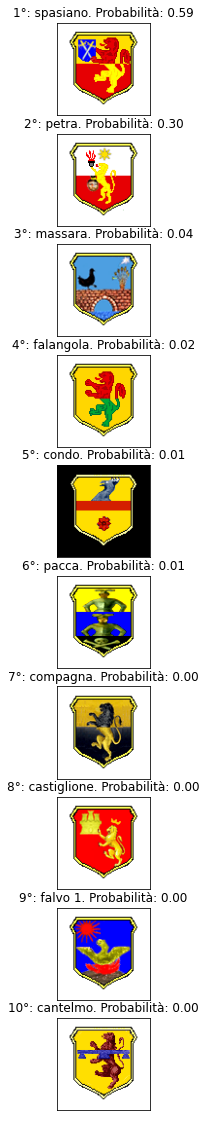

In [63]:
test("/content/drive/My Drive/Colab Notebooks/tosearch.jpeg")